# vampnet! tour

## installing vampnet!

In [1]:
%%capture
!git clone --recursive https://github.com/hugofloresgarcia/vampnet.git
!pip install ./vampnet

## quick start

set up our models, and put them in an interface

In [2]:
from pathlib import Path
import audiotools as at
import vampnet

# load the audio tokenizer
codec = vampnet.load_codec()

# load the default pretrained model
model = vampnet.load_model("hugggof/vampnet-models:vampnet-base-best")

# put them into an interface
interface = vampnet.interface.Interface(codec, model)

/home/hugo/conda/envs/yass/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


loading model hugggof/vampnet-models:vampnet-base-best from the huggingface hub.


load some example audio


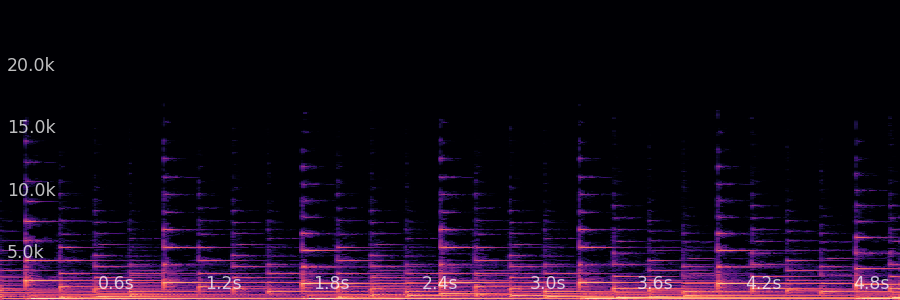
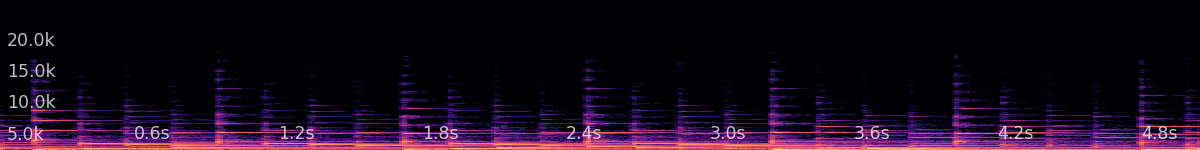

In [3]:
# load an example audio file
signal = at.AudioSignal.excerpt(vampnet.ROOT / "assets" / "example_audio/fountain.mp3", duration=5.0)

signal.widget()

encode the audio into acoustic tokens

In [4]:
# get the tokens for the audio
tokens = interface.encode(signal)

# build a mask for the tokens
mask = interface.build_mask(tokens,
    periodic_prompt=3,
    upper_codebook_mask=1,
)

tokens.shape

torch.Size([1, 9, 430])

generate output tokens with vampnet

In [5]:

# generate the output tokens
output_tokens = interface.vamp(
    tokens, mask, return_mask=False,
    sampling_temperature=1.0,
    typical_filtering=True,
    top_p=0.8,
    sample_cutoff=1.0,
)

# convert them to a signal
output_signal = interface.to_signal(output_tokens).cpu()

# save the output signal
Path("scratch").mkdir(exist_ok=True)
output_signal.write("scratch/output.wav")

will process 1 chunks of length 430


vamping chunks: 1it [00:00,  1.65it/s]


NameError: name 'Path' is not defined

: 

## adding a dataset for fine tuning or training

yass uses a duckdb database to manage data.

first, let's init our db if we havent.

In [ ]:
vampnet.db.init()

running create_dataset_table
running create_audio_file_table
running create_ctrl_sig_table
running create_split_table
done! :)


now, let's add an audio folder to our database.

In [ ]:
# this is what we will call our dataset
dataset = "example"

# create the dataset
vampnet.db.create.create_dataset(
    audio_folder="assets/example_audio",
    dataset_name=dataset,
)

looking for audio files in assets/example_audio
Found 2 audio files


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 15.01it/s]

Processed 2 audio files
of which 0 failed
done! committing to the db.


preprocess the dataset

In [ ]:
vampnet.db.preprocess.preprocess(dataset=dataset)

Found dataset example at assets/example_audio
Found 2 audio files
processing control signal dac


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

Processed 2 audio files
of which 0 failed
committing changes to the db.


pick a model to fine tune

In [ ]:
# we'll just pick the first one available online.
available_hub_models = vampnet.list_hub_models()
print(f"available hub models: {available_hub_models}")

# load the hub model
model_id = available_hub_models[0]
print(f"using model: {model_id}")

available hub models: ['hugggof/vampnet-models:vampnet-base-best']
using model: hugggof/vampnet-models:vampnet-base-best


## fine tuning a pretrained model

fine tune!

`vampnet.fine_tune.fine_tune` will return a `vampnet.interface.Interface`, which we can use to upload our model to the HF hub.

In [ ]:
finetuned_interface = vampnet.fine_tune.fine_tune(
    dataset=dataset,
    model_name=model_id,
    num_iters=1000, # fine tune for 1000 steps
)

seed: 10110100
fine-tuning, will validate on the training data!!!
Loading dataset example
Using 2 rows for split None
Loading dataset example
Using 2 rows for split None
Loading dataset example
Using 2 rows for split None
FINE TUNING!
loading model from hugggof/vampnet-models:vampnet-base-best
loading model hugggof/vampnet-models:vampnet-base-best from the huggingface hub.
Compiling model


tracker opened

Finished compiling model
initialized state.
trimmed batch size: 26
trimmed val batch size: 26
initialized dataloader.
marked only lora as trainable.
starting training loop.


Output()

## pretrained models

view a list of locally available pretrained models, and load a local pretrained model

In [ ]:
available_local_models = vampnet.list_local_models()
print(f"available_local_models: {available_local_models}")

# load the local model
model_name = available_local_models[0]
model = vampnet.load_local_model(model_name)

available_local_models: ['vampnet-base-best']


view a list of available pretrained models in the HF hub, and load one

In [ ]:
available_hub_models = vampnet.list_hub_models()
print(f"available hub models: {available_hub_models}")

# load the hub model
model_id = available_hub_models[0]
model = vampnet.load_hub_model(model_id)

available hub models: ['hugggof/yass:vampnet-base-best']


models/vampnet-base-best.vampnet:   0%|          | 0.00/12.0 [00:00<?, ?B/s]

### export
export the model after training.

this copies the best model from the `runs` directory to the `models` directory, according to your config. 
optionally, you can upload the model to the huggingface_hub.

this step is also necessary to use the model's gradio UI.

if you also want to upload to huggingface, make sure to run `huggingface-cli login` on your terminal first.


In [ ]:
import yapecs
import vampnet
vampnet = yapecs.compose('vampnet', ['config/vampnet.py'])
vampnet.export.export_model()

Model saved locally to /home/hugo/yass/models/vampnet-base-best.vampnet
Creating repo hugggof/yass on the hub.
Uploading model to hugggof/yass


vampnet-base-best.vampnet:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Model uploaded to hugggof/yass. !!!
you may now use the model in the interface by running `yass.load_hf_model('hugggof/yass:vampnet-base-best')`
